In [1]:
import warnings

warnings.simplefilter("ignore", FutureWarning)

warnings.simplefilter("ignore", RunetimeWarning)


warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module=r"squidpy\.pl\._spatial_utils"
)

warnings.filterwarnings(
    "ignore",
    category=anndata._core.views.ImplicitModificationWarning
)

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
import anndata as ad

import seaborn as sns
import pickle


from matplotlib.colors import ListedColormap



/software/cellgen/team298/ls34/vqgraph/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
#%matplotlib inline
sc.settings.figdir = "fig4"
sc.settings.set_figure_params(dpi_save=300, facecolor="white", frameon=False, figsize=(8,8))


# dotplot of expression

In [4]:
FILE_NAME = "adata_combined_new.h5ad.final.filtered"
PATH2=f'/nfs/team298/ls34/adult_skin/final_adatas/{FILE_NAME}'
adata_5k=sc.read_h5ad(PATH2)
adata_5k=adata_5k[adata_5k.obs["tech"]=="xenium"]


def remove_markers(LIST):
    try: 
        LIST = {key: [gene for gene in genes if gene in adata_5k.var_names] 
                           for key, genes in LIST.items()}
    except: 
        LIST =[gene for gene in LIST if gene in adata_5k.var_names]
    return LIST

  

In [5]:
CATEGORY="lvl5_annotation"
NICHE_COLUMN   = "niche19"


In [6]:
sc.pp.normalize_total(adata_5k, target_sum=1e4)
sc.pp.log1p(adata_5k)
adata_5k = adata_5k[adata_5k.obs["niche19"]!="Nonspecific/folded"]

/software/cellgen/team298/ls34/vqgraph/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


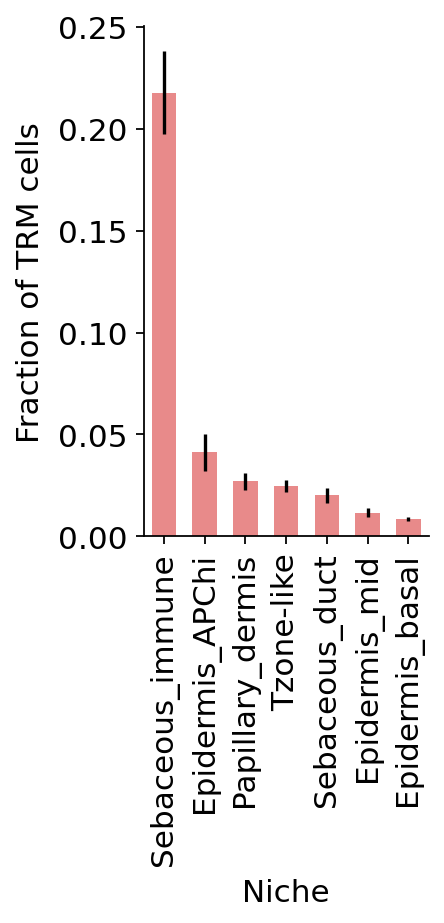

In [7]:
# --------------------------------------------------
# 1  Compute per-slide TRM fractions
# --------------------------------------------------
mask_trm = adata_5k.obs["lvl5_annotation"].astype(str).str.startswith("TRM_")

df = (
    adata_5k.obs.assign(is_TRM=mask_trm)
        .groupby(["info_id6", NICHE_COLUMN])
        .agg(total_cells=("is_TRM", "size"),
             trm_cells  =("is_TRM", "sum"))
        .reset_index()
)
df["prop_TRM"] = df["trm_cells"] / df["total_cells"]

# --------------------------------------------------
# 2  Mean ± SEM per niche
# --------------------------------------------------
stats = (
    df.groupby(NICHE_COLUMN)["prop_TRM"]
      .agg(mean="mean",
           sem =lambda x: x.std(ddof=1) / np.sqrt(len(x)))
      .reset_index()
      .sort_values("mean", ascending=False)
)

# keep only the top-7 niches
stats_top = stats.head(7)

# --------------------------------------------------
# 3  Plot
# --------------------------------------------------
plt.figure(figsize=(3, 6))
sns.barplot(
    data=stats_top,
    x=NICHE_COLUMN,
    y="mean",
    order=stats_top[NICHE_COLUMN],   # preserve the sorted order
    yerr=stats_top["sem"],
    color="#f87a7b",
    width=0.6                     # <-- narrower bars (default ≈ 0.8)
)

ax = plt.gca()
ax.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.xticks(rotation=90, ha="center")
plt.xlabel("Niche", labelpad=6)
plt.ylabel("Fraction of TRM cells", labelpad=6)
plt.title("")                    # no title
plt.tight_layout()
plt.savefig("fig4/4c_TRM_prevelance1.pdf", dpi=300, bbox_inches="tight")

plt.show()

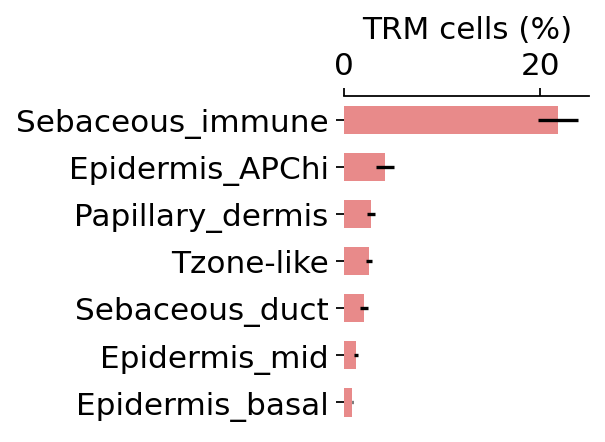

In [8]:

# --------------------------------------------------
# 1  Compute per-slide TRM fractions
# --------------------------------------------------
mask_trm = adata_5k.obs["lvl5_annotation"].astype(str).str.startswith("TRM_")

df = (
    adata_5k.obs.assign(is_TRM=mask_trm)
        .groupby(["info_id6", NICHE_COLUMN])
        .agg(total_cells=("is_TRM", "size"),
             trm_cells  =("is_TRM", "sum"))
        .reset_index()
)
df["prop_TRM"] = df["trm_cells"] / df["total_cells"]

# --------------------------------------------------
# 2  Mean ± SEM per niche (in %)
# --------------------------------------------------
stats = (
    df.groupby(NICHE_COLUMN)["prop_TRM"]
      .agg(mean="mean",
           sem =lambda x: x.std(ddof=1) / np.sqrt(len(x)))
      .reset_index()
)
stats["mean"] *= 100  # convert to percent
stats["sem"]  *= 100

stats = stats.sort_values("mean", ascending=False)
stats_top = stats.head(7)

# --------------------------------------------------
# 3  Plot (horizontal + x-axis on top)
# --------------------------------------------------
plt.figure(figsize=(4, 3))
sns.barplot(
    data=stats_top,
    x="mean",
    y=NICHE_COLUMN,
    order=stats_top[NICHE_COLUMN],
    xerr=stats_top["sem"],
    color="#f87a7b",
    width=0.6
)

ax = plt.gca()
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
ax.grid(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.xlabel("TRM cells (%)", labelpad=6)
plt.ylabel("", labelpad=6)
plt.tight_layout()
plt.savefig("fig4/4c_TRM_prevelance1_smaller.pdf", dpi=300, bbox_inches="tight")

plt.show()